<a href="https://colab.research.google.com/github/omriak/omri_project_files/blob/main/training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/omriak/omri_project_files/blob/main/training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Resizing
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

In [ ]:
def upsample_100(data):
    current_N = np.shape(data)
    new_data = np.zeros(shape=(100,current_N[1],current_N[2]))
    for i in range(0,100):
        new_data[i,:,:] = data[int(np.floor((current_N[0]*i)/100)),:,:]
    return new_data

def DFS():
    DFS_indexlist = np.array([2, 21, 9, 10,  11,  12, 25,  12,  24,  12,  11, 10, 9,
                             21, 3, 4, 3, 21, 5, 6, 7, 8, 23, 8, 22, 8, 7, 6, 5, 21,
                             2, 1, 13, 14, 15, 16, 15, 14, 13, 1, 17, 18, 19, 20, 19,
                             18, 17, 1, 2])
    DFS_indexlist = DFS_indexlist-1
    return DFS_indexlist

# Nicely formatted time string

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# paths and variables
# main path:
path_folder = '/content'

# action folder:
# only one action.
action_folder = 'A001'  

# file_name='S001C001P001R002A001.skeleton.npy' example.


DATA_PATH=os.path.join(path_folder,action_folder)
DATA_PATH_A=os.path.join(path_folder)
print(f"your data path: {DATA_PATH}")

#loading the training data.
training_binary_path = os.path.join(DATA_PATH_A,f'training_data_arrange_{action_folder}.npy')
print(training_binary_path)

your data path: /content/A001
/content/training_data_arrange_A001.npy


In [ ]:
print("Loading previous training pickle...")
training_data = np.load(training_binary_path)

Loading previous training pickle...


In [ ]:
def build_image_resizer(height,width):
    model = Sequential()
    model.add(Resizing(64, 64, interpolation="bilinear" , input_shape=(height,width,3)))
    return model

def build_generator(seed_size):
    # seed_size is z+c where c is the class sagment
    model = Sequential()
    
    #input layer
    model.add(Dense(4*4*512,activation="relu",input_dim=seed_size)) 
    model.add(Reshape((4,4,512)))

    # Mid CNN layer
    model.add(UpSampling2D(size=2,interpolation = 'bilinear'))
    model.add(Conv2D(512,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(256,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(128,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(64,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    # Final CNN layer
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(3,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(Activation("tanh"))
    model.add(Resizing(64, 64, interpolation="bilinear" , input_shape=(128,128,3)))
    return model


def build_discriminator(image_shape):
    model = Sequential()
    
    #input layer first using resizer
    model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), input_shape=image_shape, padding="same",use_bias = False))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
generator = build_generator(106)
discriminator = build_discriminator((64,64,9))
resizer = build_image_resizer(100,49)
Model.summary(resizer)
Model.summary(generator)
Model.summary(discriminator)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 64, 64, 3)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              876544    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         2359296   
________________________________________

In [ ]:
#traning module
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def add_class(images):
    images = images.numpy()
    s = images.shape
    zero = np.zeros((s[0], s[1], s[2], 5))  
    one = np.ones((s[0], s[1], s[2], 1)) 
    class1 = np.append(zero, one, axis=3)
    return  np.append(images, class1, axis=3)
    

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,seed):
    generator_resizer = build_image_resizer(128,128)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        generated_images = generator(seed, training=True)
        generated_images = tf.concat([generated_images,tf.zeros((generated_images.shape[0],64,64,5)), tf.ones((generated_images.shape[0],64,64,1))], 3)
        #generated_images = generator_resizer(generated_images, training=False)
        #proto_tensor = tf.make_tensor_proto(generated_images)
        #generated_images = tf.make_ndarray(proto_tensor)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
    
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables),
    experimental_aggregate_gradients=False)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables),
    experimental_aggregate_gradients=False)
    return gen_loss,disc_loss

def train(dataset, epochs):
    seed = np.random.normal(0, 1,100)
    c = np.asarray((0,0,0,0,0,1))
    fixed_seed = np.append(seed,c)
    
    seed = np.random.normal(0, 1,(BATCH_SIZE,100))
    s = seed.shape
    zero = np.zeros((s[0], 5))  
    one = np.ones((s[0], 1)) 
    class1 = np.append(zero, one, axis=1)
    seed = np.append(seed, class1, axis=1)
    
    
    start = time.time()

    gen_loss_total_list = []
    disc_loss_total_list = []

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []
        #i=0
        for image_batch in dataset:
            t = train_step(image_batch,seed)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            #i = i+1
            #print('image_batch'+str(i))

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'f' {hms_string(epoch_elapsed)}')
        #save_images(epoch,fixed_seed)

        gen_loss_total_list.append(g_loss)
        disc_loss_total_list.append(d_loss)
        

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')
    return gen_loss_total_list , disc_loss_total_list



In [ ]:

training_data_r = resizer(training_data, training=False)
print(training_data_r.shape)
s = training_data_r.shape
zero = np.zeros((s[0], s[1], s[2], 5))  
one = np.ones((s[0], s[1], s[2], 1)) 
class1 = np.append(zero, one, axis=3)
training_data_r1 = np.append(training_data_r, class1, axis=3)
print(training_data_r1.shape)


(939, 64, 64, 3)
(939, 64, 64, 9)


In [ ]:
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000
SEED_SIZE = 106
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data_r1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#print(train_dataset.size)
gen_loss , disc_loss = train(train_dataset, EPOCHS)


Epoch 1, gen loss=3.4737980365753174,disc loss=0.6298173069953918, 0:00:21.53
Epoch 2, gen loss=3.765099287033081,disc loss=0.9814212322235107, 0:00:04.40
Epoch 3, gen loss=2.6384377479553223,disc loss=1.1515485048294067, 0:00:04.33
Epoch 4, gen loss=1.4820353984832764,disc loss=1.3951202630996704, 0:00:04.36
Epoch 5, gen loss=1.5036600828170776,disc loss=1.088418960571289, 0:00:04.35
Epoch 6, gen loss=2.022909641265869,disc loss=0.9686053395271301, 0:00:04.36
Epoch 7, gen loss=2.1838903427124023,disc loss=0.7695820927619934, 0:00:04.34
Epoch 8, gen loss=2.2552337646484375,disc loss=0.9734851121902466, 0:00:04.40
Epoch 9, gen loss=2.3978469371795654,disc loss=0.7154448628425598, 0:00:04.38
Epoch 10, gen loss=1.9387820959091187,disc loss=0.9988343119621277, 0:00:04.38
Epoch 11, gen loss=2.2592265605926514,disc loss=0.7875459790229797, 0:00:04.40
Epoch 12, gen loss=1.8666175603866577,disc loss=0.9686287045478821, 0:00:04.42
Epoch 13, gen loss=2.2299184799194336,disc loss=0.77325195074081

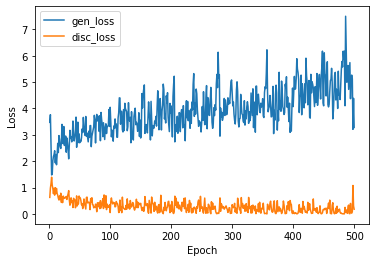

In [11]:
plt.plot(np.linspace(1,len(gen_loss),len(gen_loss)),gen_loss)
plt.plot(np.linspace(1,len(disc_loss),len(disc_loss)),disc_loss)
plt.legend(["gen_loss", "disc_loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
action_folder = 'training_data'
DATA_PATH = '/content/drive/MyDrive/Project_OmriAkrish/project_code_files/training_data'
DATA_PATH=os.path.join(DATA_PATH,action_folder)
print(DATA_PATH)
generator.save(os.path.join(DATA_PATH,"generator1.h5"))
discriminator.save(os.path.join(DATA_PATH,"discriminator1.h5"))

/content/drive/MyDrive/Project_OmriAkrish/project_code_files/training_data/training_data


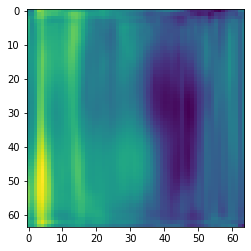

In [15]:
seed = np.random.normal(0, 1,100)
c = np.asarray((0,0,0,0,0,1))
fixed_seed = np.append(seed,c)
generated_image = generator(np.expand_dims(fixed_seed, axis=0), training=False)

plt.imshow(generated_image[0, :, :, 0])

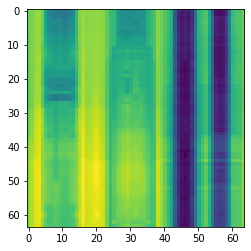

In [17]:
plt.imshow(training_data_r[32, :, :, 0])

In [ ]:
jdjcvndjf djxnskd cjdnaksnd
cjdnaksnd 